# Task Space Coordination and Human Shared Control
## (Corresponding to Chapter 12)

### Notebook Initialization

In [1]:
# Numeric and symbolic libraries
import sympy as sym
import numpy as np
sym.init_printing()

# Plot libraries for main plots
from matplotlib.pyplot import subplots, rcParams
__colors = rcParams['axes.prop_cycle'].by_key()['color']
def get_color(index):
    return __colors[index%10]

# Plot libraries for animations
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

## Load Single-Agent Modeling and IDA-PBC

In [2]:
# Load single-agent models
%run models.ipynb
from systemsim.mechanical import SymbolicIDAPBCAgent
from systemsim.symbolic import Equation

In [3]:
# Load agent equations of motion and single-agent IDA-PBC control
model_2_link = flexible_joint_robot(2)
model_3_link = flexible_joint_robot(3)
model_uav = planar_uav()
model_haptic = haptic_input(links=2)

## Agent Initialization


In [4]:
# Initialize 2 link flexible-joint robot
pars_2_link = {  
    'L': 0.5,
    'M': 2,
    'I_a': 0.05,
    'I_b': 0.05,
    'k': 10,
    'kd': 0.5,
    'kv': 0.5,
    'b_x' : -1,
    'b_y' : 0,
}
arm2 = SymbolicIDAPBCAgent(
    model_2_link,
    pars_2_link,
    q_initial=np.array([-1,2,-1,2]),
    p_initial=np.array([0,0,0,0])
)

# Initialize 3 link flexible-joint robot
pars_3_link = {  
    'L': 0.5,
    'M': 2,
    'I_a': 0.05,
    'I_b': 0.05,
    'k': 10,
    'kd': 0.5,
    'kv': 0.5,
    'b_x' : 1,
    'b_y' : 1,
}
arm3 = SymbolicIDAPBCAgent(
    model_3_link,
    pars_3_link,
    q_initial=np.array([1,2,0.5,1,2,0.5]),
    p_initial=np.array([0,0,0,0,0,0])
)

# Initialize UAV
k1val = 2
eps = 0.1
pars_uav = {  
    'g': 9.81,
    'epsilon': eps,
    'k_1': k1val,
    'k_2': 1/(1.5*eps),
    'k_3': (5+0.1)*k1val*eps,
    'K_v1': 1*0,
    'K_v2': 20*0,
    'K_d1': 2,
    'K_d2': 2,
    'base': 0.4
}
uav = SymbolicIDAPBCAgent(
    model_uav,
    pars_uav,
    q_initial=np.array([1, -1, 10/180*3.14]),
    p_initial=np.array([0,0,0])
)

## Autonomous Docking with Heterogeneous Flexible-Joint Robots
Network of a 2-link and 3-link flexible-joint robot, which prepare to grasp a UAV at a cooperatively agreed location.

In [5]:
from systemsim.network import DistributedIDAPBC

# Specify relative configuration of all edges in the network
directed_edges = {
    (uav, arm3): (np.array([[1, 0],[0, 1]]), np.array([0.2,0])),
    (uav, arm2): (np.array([[1, 0],[0, 1]]), np.array([-0.2,0])),
} 
# Copy edges and negate sign to make undirected edges
undirected_edges = DistributedIDAPBC.undirected_edges(directed_edges)

# There are no leaders in the network
leaders = {}
            
# Initialize the network
network = DistributedIDAPBC([uav, arm2, arm3], undirected_edges, leaders)

# Run simulation
time_range = np.arange(start=0,step=0.1,stop=15)
network.simulate(time_range)

# Show animation of results
network.make_animation_data(1, 25)
animationfigure = network.get_animation_figure([-1,1],[-1.1,1.55],'Docking of UAV with Flexible-Joint Robots (Animation of Figure 21)')
iplot(animationfigure)

#### Plot code for Figure 22

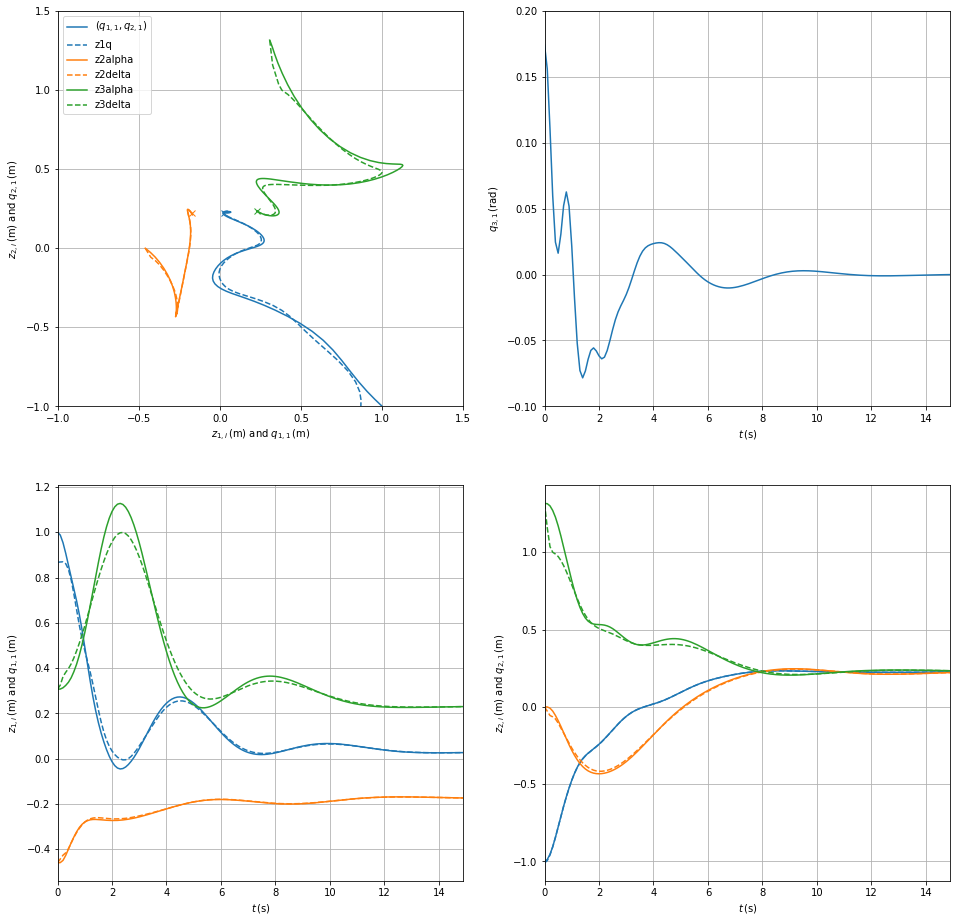

In [6]:
# Figure and colors
figure, ((travel, angles),(hor, vert)) = subplots(nrows=2, ncols=2, figsize=(16, 16))
blue, orange, green, red = [get_color(code) for code in range(4)]

# Grids
for ax in [travel, angles, hor, vert]:
    ax.grid(True)

# UAV plots
q1, q2, q3 = [uav.state_trajectory[q,:] for q in [0,1,2]]
travel.plot(q1,q2, color=blue, label='$(q_{1,1}, q_{2,1})$')
travel.plot(q1[-1],q2[-1], color=blue, marker='x')
travel.plot(uav.z_trajectory[0, :],uav.z_trajectory[1, :], color=blue, linestyle='dashed',label='z1q')
angles.plot(time_range, q3, color=blue)   
hor.plot(time_range, q1, color=blue)
hor.plot(time_range, uav.z_trajectory[0, :], color=blue, linestyle='dashed')
vert.plot(time_range, uav.z_trajectory[1, :], color=blue, linestyle='dashed')
vert.plot(time_range, q2, color=blue)

# Two link arm plots
arm2_endpoints = np.stack([np.array(arm2.get_animation_kinematics(arm2.state_trajectory[:, k]))[:,-1] for (k, time) in enumerate(arm2.simulation_time)], axis=1)
travel.plot(arm2_endpoints[0, :],arm2_endpoints[1, :], color=orange,  label='z2alpha')
travel.plot(arm2_endpoints[0,-1],arm2_endpoints[1,-1], color=orange, marker='x')
travel.plot(arm2.z_trajectory[0, :],arm2.z_trajectory[1, :], color=orange, linestyle='dashed',label='z2delta')
hor.plot(time_range, arm2_endpoints[0, :], color=orange)
hor.plot(time_range, arm2.z_trajectory[0, :], color=orange, linestyle='dashed')
vert.plot(time_range, arm2.z_trajectory[1, :], color=orange, linestyle='dashed')
vert.plot(time_range, arm2_endpoints[1, :], color=orange)

# Three link arm plots
arm3_endpoints = np.stack([np.array(arm3.get_animation_kinematics(arm3.state_trajectory[:, k]))[:,-1] for (k, time) in enumerate(arm2.simulation_time)], axis=1)
travel.plot(arm3_endpoints[0, :],arm3_endpoints[1, :], color=green, label='z3alpha')
travel.plot(arm3_endpoints[0,-1],arm3_endpoints[1,-1], color=green, marker='x')
travel.plot(arm3.z_trajectory[0, :],arm3.z_trajectory[1, :], color=green, linestyle='dashed',label='z3delta')
hor.plot(time_range, arm3_endpoints[0, :], color=green)
hor.plot(time_range, arm3.z_trajectory[0, :], color=green, linestyle='dashed')
vert.plot(time_range, arm3.z_trajectory[1, :], color=green, linestyle='dashed')
vert.plot(time_range, arm3_endpoints[1, :], color=green)

# Axis limits
t_end = time_range[-1]
hor.set_xlim([0, t_end])
vert.set_xlim([0, t_end])
angles.set_xlim([0, t_end])

travel.set_xlim([-1, 1.5])
travel.set_ylim([-1, 1.5])
angles.set_ylim([-0.1, 0.2])
    
# Legends and labels
travel.set_xlabel('$z_{1, i}\,$(m) and $q_{1,1}\,$(m)')
travel.set_ylabel('$z_{2, i}\,$(m) and $q_{2,1}\,$(m)')

hor.set_ylabel('$z_{1, i}\,$(m) and $q_{1,1}\,$(m)')
vert.set_ylabel('$z_{2, i}\,$(m) and $q_{2,1}\,$(m)')
angles.set_xlabel('$t\,$(s)')
hor.set_xlabel('$t\,$(s)')
vert.set_xlabel('$t\,$(s)')
angles.set_ylabel('$q_{3,1}\,$(rad)')
travel.legend(loc='upper left')

## Haptic Shared Control
Same robotic manipulators and UAV as before, with an additional 2-link haptic manipulator, synchronized to the UAV.

A human operator applies PD control to this scaled manipulator to steer the UAV to the origin, while the flexible-joint manipulators continue their docking task.

Precise human feedback is not required as docking remains autonomous. However, the human can alter the outcome of the otherwise arbitrary formation location.

In [7]:
from systemsim.network import Interconnection
from systemsim.linear import Integrator

# haptic input parameters
pars_haptic = {  
    'L': 0.1,
    'M': 0.2,
    'I_a': 0.05/10,
    'kd': 0.5/5,
    'kv': 0.5/5,
    'b_x' : -1.5,
    'b_y' : 0,
    'scale': 5,
}

# Initialize haptic manipulator
haptic_q_initial=np.array([0,np.pi/4])
haptic = SymbolicIDAPBCAgent(
    model_haptic,
    pars_haptic,
    haptic_q_initial,
    np.zeros(2)
)
r_haptic_uav = np.array([-0.5, 0])
z0_haptic = haptic.z(haptic_q_initial)
z0_uav = z0_haptic + r_haptic_uav


# Reinitialize UAV, synched with manipulator
uav = SymbolicIDAPBCAgent(
    model_uav,
    pars_uav,
    q_initial=np.append(z0_haptic+r_haptic_uav, 0),
    p_initial=np.array([0,0,0])
)

# Edges in the network
directed_edges = {
    (uav, arm3): (np.array([[1, 0],[0, 1]]), np.array([0.2,0])),
    (uav, arm2): (np.array([[1, 0],[0, 1]]), np.array([-0.2,0])),    
    (haptic, uav): (np.array([[1, 0],[0, 1]]), r_haptic_uav),
} 
undirected_edges = DistributedIDAPBC.undirected_edges(directed_edges)

# There are no leaders (instead, the human acts as leader later on)
leaders = {}

# The IDA-PBC network is a (big) system, controlled through the human input acting on the
# haptic manipulator and the shaped UAV
input_connections = [
    ([haptic, uav], None)
]

# The IDA-PBC output is chosen to be the UAV velocity
output_connections = [
    {uav: 1}
]

# Initialize the network
net = DistributedIDAPBC([uav, arm2, arm3, haptic], undirected_edges, leaders, input_connections, output_connections)

# The human proportional control is modeled as an integrator of the velocity
integrator = Integrator(z0_uav)

# The closed loop system is the IDA-PBC network with the human controller
systems = [net, integrator]
human_kp = 2
human_kd = 1
connections = {
    (integrator, net): -human_kp, # Proportional Control
    (net, net): -human_kd,        # Derivative Control
    (net, integrator): 1   # System ouput to controller
}

# Simulate the closed loop
closedloop = Interconnection(systems, connections)
time_range=np.arange(start=0,step=0.1,stop=30.1)
closedloop.simulate(time_range)

# Animate the IDA-PBC components
net.make_animation_data(1, 25)
animationfigure = net.get_animation_figure([-2,1],[-1,1.5],'Haptic Shared Control (Animation of Figure 23)')
iplot(animationfigure)

#### Plot code for Figure 24


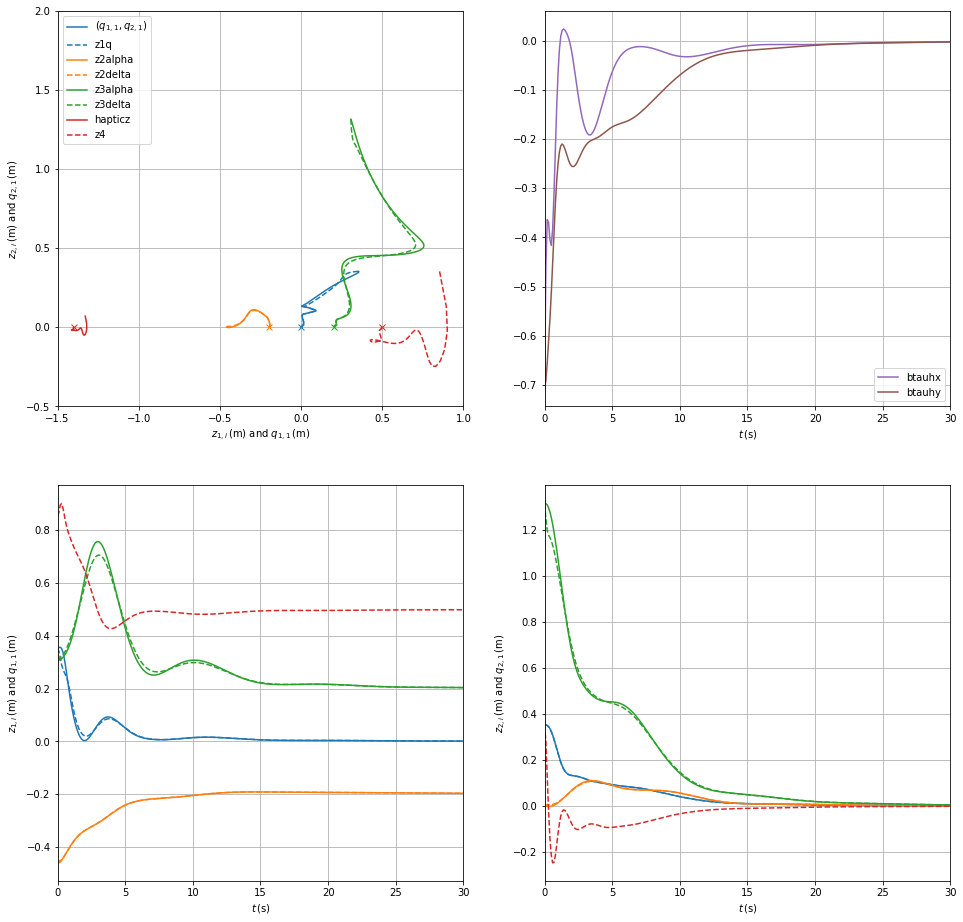

In [8]:
# Figure and colors
figure, ((travel, controls),(hor, vert)) = subplots(nrows=2, ncols=2, figsize=(16, 16))
blue, orange, green, red = [get_color(code) for code in range(4)]

# Grids
for ax in [travel, controls, hor, vert]:
    ax.grid(True)

# UAV plots
q1, q2, q3 = [uav.state_trajectory[q,:] for q in [0,1,2]]
travel.plot(q1,q2, color=blue, label='$(q_{1,1}, q_{2,1})$')
travel.plot(q1[-1],q2[-1], color=blue, marker='x')
# angles.plot(time_range, q3, color=blue)   
hor.plot(time_range, q1, color=blue)
vert.plot(time_range, q2, color=blue)
travel.plot(uav.z_trajectory[0, :],uav.z_trajectory[1, :], color=blue, linestyle='dashed',label='z1q')
hor.plot(time_range, uav.z_trajectory[0, :], color=blue, linestyle='dashed')
vert.plot(time_range, uav.z_trajectory[1, :], color=blue, linestyle='dashed')

# Two link arm plots
arm2_endpoints = np.stack([np.array(arm2.get_animation_kinematics(arm2.state_trajectory[:, k]))[:,-1] for (k, time) in enumerate(arm2.simulation_time)], axis=1)
travel.plot(arm2_endpoints[0, :],arm2_endpoints[1, :], color=orange,  label='z2alpha')
travel.plot(arm2_endpoints[0,-1],arm2_endpoints[1,-1], color=orange, marker='x')
travel.plot(arm2.z_trajectory[0, :],arm2.z_trajectory[1, :], color=orange, linestyle='dashed',label='z2delta')
hor.plot(time_range, arm2_endpoints[0, :], color=orange)
hor.plot(time_range, arm2.z_trajectory[0, :], color=orange, linestyle='dashed')
vert.plot(time_range, arm2.z_trajectory[1, :], color=orange, linestyle='dashed')
vert.plot(time_range, arm2_endpoints[1, :], color=orange)

# Three link arm plots
arm3_endpoints = np.stack([np.array(arm3.get_animation_kinematics(arm3.state_trajectory[:, k]))[:,-1] for (k, time) in enumerate(arm2.simulation_time)], axis=1)
travel.plot(arm3_endpoints[0, :],arm3_endpoints[1, :], color=green, label='z3alpha')
travel.plot(arm3_endpoints[0,-1],arm3_endpoints[1,-1], color=green, marker='x')
travel.plot(arm3.z_trajectory[0, :],arm3.z_trajectory[1, :], color=green, linestyle='dashed',label='z3delta')
hor.plot(time_range, arm3_endpoints[0, :], color=green)
hor.plot(time_range, arm3.z_trajectory[0, :], color=green, linestyle='dashed')
vert.plot(time_range, arm3.z_trajectory[1, :], color=green, linestyle='dashed')
vert.plot(time_range, arm3_endpoints[1, :], color=green)

# Haptic plots
haptic_endpoints = np.stack([np.array(haptic.get_animation_kinematics(haptic.state_trajectory[:, k]))[:,-1] for (k, time) in enumerate(arm2.simulation_time)], axis=1)
travel.plot(haptic_endpoints[0, :],haptic_endpoints[1, :], color=red, label='hapticz')
travel.plot(haptic_endpoints[0,-1],haptic_endpoints[1,-1], color=red, marker='x')
travel.plot(haptic.z_trajectory[0,-1],haptic.z_trajectory[1,-1], color=red, marker='x')
travel.plot(haptic.z_trajectory[0, :],haptic.z_trajectory[1, :], color=red, linestyle='dashed',label='z4')
hor.plot(time_range, haptic.z_trajectory[0, :], color=red, linestyle='dashed')
vert.plot(time_range, haptic.z_trajectory[1, :], color=red, linestyle='dashed')

# human force
human_control_signal = -human_kp*integrator.output_trajectory-human_kd*net.output_trajectory
controls.plot(time_range, human_control_signal[0,:],color=get_color(4),label='btauhx')
controls.plot(time_range, human_control_signal[1,:],color=get_color(5),label='btauhy')
controls.legend()
controls.legend(loc='lower right')

# Axis limits
t_end = time_range[-1]
hor.set_xlim([0, t_end])
vert.set_xlim([0, t_end])
controls.set_xlim([0, t_end])

travel.set_xlim([-1.5, 1])
travel.set_ylim([-0.5, 2])
    
# Legends and labels
travel.set_xlabel('$z_{1, i}\,$(m) and $q_{1,1}\,$(m)')
travel.set_ylabel('$z_{2, i}\,$(m) and $q_{2,1}\,$(m)')

hor.set_ylabel('$z_{1, i}\,$(m) and $q_{1,1}\,$(m)')
vert.set_ylabel('$z_{2, i}\,$(m) and $q_{2,1}\,$(m)')
controls.set_xlabel('$t\,$(s)')
hor.set_xlabel('$t\,$(s)')
vert.set_xlabel('$t\,$(s)')
travel.legend(loc='upper left')